<a href="https://www.kaggle.com/code/gianpieroandrenacci/covid-19-new-cases-in-italy-prediction-arima?scriptVersionId=154842509" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="background-color:#800000;font-family:serif;font-size:350%;color: #fff;text-align:center;border-radius: 50px 50px;">Covid-19 new cases prediction with SARIMAX</h1>

![](https://www.aisla.it/wp-content/uploads/2020/03/home-banner-1.jpg)

* [1. Introduction](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Custom Functions](#1.2)
    * [1.3 Load the Data](#1.3)
    * [1.4 Dataset Description](#1.4)
* [2. Data preparation and exploration](#2)
    * [2.1 Data preparation](#2.1)
    * [2.2 EDA with pandas-profiling](#2.2)
	* [2.3 Geographic data analysis ](#2.3)
	* [2.4 Exploratotry data analysis](#2.4)
* [3. Build SarimaX Model](#3) 
    * [3.1 Data preparatiuon for SarimaX](#3.1)
    * [3.2 SARIMA ACF/PACF](#3.2)
    * [3.3 Find optimal hyperparameters](#3.3)
* [4. Predict and Evaluate the model](#4) 
 * [4.1 Predict](#4.1)
 * [4.2 Evaluate the model](#4.2)

<a id="1"></a>
<h1 style="background-color:#800000;font-family:Serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Introduction</h1>

**Coronavirus** is a family of viruses that are named after their spiky crown. The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that first reported in Wuhan, China. On 2/11/2020, the World Health Organization designated the name COVID-19 for the disease caused by the novel coronavirus. This notebook aims at exploring COVID-19 through data analysis and projections.

The first cases of on-ground spread Coronavirus in Italy appeared in the Northern regions of Lombardy, Veneto and Emilia-Romagna on the 20th of February

This notebook aims to **predict Italy COVID-19 new cases for the future 7 days.**

**We will use SARIMAX model.**

Other notes:

* Data collection started on the 24th of February
* GEOGRAPHICAL AREAS are taken from ISTA website (https://www.istat.it/it/archivio/222527)
* The Italian territory comprises 19 Regions and 2 Autonomous Provinces (Trento and Bolzano). We will treet 2 Autonomous Provinces as one region, called Trentino-Alto Adige.
* Data Source: Protezione Civile's git repository https://github.com/pcm-dpc/COVID-19

<a id="1.1"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Import libraries</h1>

In [1]:
!pip install geopandas
!pip install pyshp
!pip install pmdarima
!pip install ipywidgets
!pip install --force-reinstall --no-binary shapely shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - \ done
  Installing backend dependencies ... - \ done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 62.8 MB/s eta 0:00:00
  Created wheel for shapely: filename=shapely-2.0.2-cp37-cp37m-linux_x86_64.whl size=1111582 sha256=61a5499bbad0df1b53e6ccc834030aa9e87e4d157bc5d498601ec2d608563b11
  Stored in directory: /root/.cache/pip/wheels/ff/74/92/94eebb529093deb5ebb84e025fe4a26ff0f69ce8d1e6cff215
Successfully built shapely
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.0
    

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import datetime
from datetime import datetime
import calendar
import holidays

import matplotlib.dates as mdates
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#import pmdarima 
import pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders
from pandas_profiling import ProfileReport

#geopandas
import shapefile as shp
import geopandas as gpd
from pandas._libs.algos import pad

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<a id="1.2"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Custom functions</h1>

In [3]:
def create_features(df):
    """
    Creates time series features from date column
    df: dataframe
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['dayname'] =  df['date'].dt.day_name()
    df['holiday'] = df['date'].apply(lambda x: 1 if x in holidays.Italy() else 0)
    # df = df[['dayofweek','month','year','dayofyear','dayofmonth','weekofyear','holidays']]
    df.set_index('date', inplace = True)
    return df

In [4]:
def my_plot(df, colum_name, ylabel=None, title=None, start=None, end=None, navigate = 0 ):
    """
    Python function to plot a specific column of dataframe
    Possibiliti to filter: last month, last semester,last year , ytd
    df: dataframe
    colum_name : column to plot
    ylabel:  y axis label
    title: plot title
    start: start date for the plot
    end: end date for the plot
    navigate: give the possibiliti to zoom in and out for the dates range
    """
    if start is not None or end is not None:
        df = df[start:end]

    fig = px.line(df, x=df.index, y=colum_name)


    fig.update_layout(
    title= title,
    xaxis_title= "Date",
    yaxis_title= ylabel
    # plot_bgcolor = "white"

    )   

    if navigate == 1:

        fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(count=6, label="6m", step="month", stepmode="backward"),
          dict(count=1, label="YTD", step="year", stepmode="todate"),
          dict(count=1, label="1y", step="year", stepmode="backward"),
          dict(step="all")
        ])
        )
        )

    fig.update_traces(line_color='#b30000', line_width=1)

    return fig

In [5]:
# find the first and the last weekday of dataframe
def last_n_months(df,n_months):
    """
    Takes a dataframe with weekday columns and return the data from the first dayname to the last dayname
    in the dataframe n months backwards

    df: input dataframe 
    n_months: month to go backwards
    """
    # days to go backwards
    delta_days = n_months * 31 

    #last day with dayname
    last_day_name = df.loc[covid.index.max(),'dayname']
    df = df.iloc[-delta_days:].copy()

    #sort by index
    df  = df.sort_index(ascending=True)

    #filter min data with dayname
    mask = df.index.day_name().isin([last_day_name])
    min_idx = df.index[mask].min()
    #filter max data with dayname
    mask = df.index.day_name().isin([last_day_name])
    max_idx = df.index[mask].max()

    # filter dataframe
    df =  df.loc[min_idx:max_idx]

    return df

In [6]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
def error_metrics(y_test, y_pred):
    """
    Calculate the most common forecast error metrics
    y_test: variable name y
    y_pred: variable name yhat
    """
    #R2 - coefficient of determination
    R2 = sklearn.metrics.r2_score(y_test, y_pred)
    
    #Mean squared error
    MSE = sklearn.metrics.mean_squared_error(y_test, y_pred)
    
    #Root Mean squared error
    RMSE = math.sqrt(MSE)
    
    #Mean absolute error
    MAE =  sklearn.metrics.mean_absolute_error(y_test, y_pred)
    
    #Median absolute error 
    MdAE = sklearn.metrics.median_absolute_error(y_test, y_pred)
    
    #Mean percentage error
    MAPE = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

    print('R2: %.3f' % R2)
    print('MSE (Mean squared error): ' f"{MSE:,.0f}")
    print('RMSE (Root mean squared error): ' f"{RMSE:,.0f}")
    print('MAE (Mean absolute error): ' f"{MAE:,.0f}")
    print('MdAE (Median absolute error ): ' f"{MdAE:,.0f}")
    print('MAPE (Mean percentage error): ' f"{MAPE:,.2%}")
   
    return

<a id="1.3"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Load the data</h1>

![https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/assets/img/dpc-covid19-flusso-dati-it.png](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/assets/img/dpc-covid19-flusso-dati-it.png)

<ul>
<li><span style="background-color: #800000;font-size:130%; color: #ffffff;">Load the official data</span></li>
<li><span style="background-color: #800000; font-size:130%; color: #ffffff;">Data updated COVID-19 Italy: Weekly - In this dashboard we Load Data on Monday</span></li>
</ul>

In [8]:
#import data
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])
covid = df[['data','nuovi_positivi','terapia_intensiva','totale_ospedalizzati','ricoverati_con_sintomi','deceduti','totale_casi','tamponi','denominazione_regione','lat','long']].copy()

#remame columns and select only new_cases, region and date
covid.rename(columns={'nuovi_positivi': 'new_cases', 'denominazione_regione': 'region','data':'date'}, inplace= True)
#check nulls
covid.isnull().sum()

date                      0
new_cases                 0
terapia_intensiva         0
totale_ospedalizzati      0
ricoverati_con_sintomi    0
deceduti                  0
totale_casi               0
tamponi                   0
region                    0
lat                       0
long                      0
dtype: int64

<span style="background-color: #800000; font-size:130%; color: #ffffff;">There are no missing values</span>

In [9]:
#select features
covid = covid[['date','new_cases', 'region']].copy()
#check the last date for data
updated_to = covid.date.max()
#cast to string
updated_to = datetime.strftime(updated_to, '%Y-%m-%d') 
#msg
date_to = 'The data is updated to ' + updated_to

#print
box_char = '='
print(box_char*(len(date_to)+4))
print(box_char,date_to,box_char)
print(box_char*(len(date_to)+4))

= The data is updated to 2023-12-06 =


<a id="2"></a>
<h1 style="background-color:#800000;font-family:Serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Data preparation and exploration (EDA)</h1>

<p><strong>Exploratory data analysis (EDA)</strong> is a process of examining and analyzing data in order to understand its characteristics and patterns. It is an iterative process that involves generating hypotheses, testing them, and refining them based on the data.</p>
<p><strong>EDA is an important step in the data analysis process</strong>, as it helps to identify trends, patterns, and relationships in the data that may not be immediately apparent. EDA typically involves the use of graphical and statistical tools to visualize and summarize the data, as well as the use of data manipulation and transformation techniques to prepare the data for further analysis</p>

<a id="2.1"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Data preparation</h1>

In [10]:
#preapare data for region analysis
covid_reg = covid.groupby(['date','region'], as_index = False)['new_cases'].sum().copy()

In [11]:
#preapare data for eda and forecast
covid = covid.groupby('date', as_index = False)['new_cases'].sum().copy()
#create features (see custom functions above)
covid = create_features(covid)

In [12]:
#visualize
covid.head(5)

new_cases  dayofweek  month  year  dayofyear  dayofmonth  \
date                                                                   
2020-02-24        221          0      2  2020         55          24   
2020-02-25         93          1      2  2020         56          25   
2020-02-26         78          2      2  2020         57          26   
2020-02-27        250          3      2  2020         58          27   
2020-02-28        238          4      2  2020         59          28   

            weekofyear    dayname  holiday  
date                                        
2020-02-24           9     Monday        0  
2020-02-25           9    Tuesday        0  
2020-02-26           9  Wednesday        0  
2020-02-27           9   Thursday        0  
2020-02-28           9     Friday        0


<a id="2.2"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">EDA with pandas-profiling</h1>

<p><strong>Pandas profiling</strong> is a Python library that generates a detailed report of a Pandas DataFrame. It provides a visual summary of the DataFrame's content, including information about the number of rows and columns, the data types of each column, the number of missing values in each column, and the distribution of unique values in each column.</p>
<p>The report also includes statistical measures such as the mean, median, and standard deviation of each numeric column, as well as plots of the distribution of each column. <strong>Pandas profiling is useful for quickly understanding the characteristics of a dataset</strong> and identifying potential issues, such as missing values or data inconsistencies.</p>

# EDA using pandas-profiling for 2022

In [13]:
#year of analysis
year = 2022

#filt dataframe
covid_profiling = covid.loc[covid.index.year == year]

# remove day index and unusefull column for the analysis
covid_profiling = covid_profiling[['new_cases', 'dayofweek', 'month',  'dayofyear', 'dayofmonth',
       'weekofyear', 'holiday']].reset_index(drop=True, inplace = False)


#generate profile
profile = ProfileReport(covid_profiling, explorative=True)

In [14]:
# generate report
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<a id="2.3"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Geographic data analysis</h1>

**Shape Italy region files are taken from Italian Nanional Statistic institute (ISTAT):** [https://www.istat.it/en/](https://www.istat.it/en/)

For geocoding we utilize Geopandas python library: [Geopandas.org](https://geopandas.org/en/stable/)


><span style="background-color: #800000;font-size:130%; color: #ffffff;">Our goal is to plot Italy regions new cases for the last day</span>

In [15]:
#regions data
covid_reg.head(5)

date          region  new_cases
0 2020-02-24 18:00:00         Abruzzo          0
1 2020-02-24 18:00:00      Basilicata          0
2 2020-02-24 18:00:00        Calabria          0
3 2020-02-24 18:00:00        Campania          0
4 2020-02-24 18:00:00  Emilia-Romagna         18

In [16]:
#set date index
covid_reg.set_index('date', inplace = True)

#merge 'P.A. Bolzano' and P.A. Trento' region beacouse in Istat regions they are classified as 'Trentino-Alto Adige'

#Filter
mask1 = covid_reg['region'] == 'P.A. Bolzano' 
mask2 = covid_reg['region'] == 'P.A. Trento'

#merge
covid_reg.loc[mask1,'new_cases']= covid_reg.loc[mask1,'new_cases'] + covid_reg.loc[mask2,'new_cases']  
covid_reg.loc[mask1,'region']  = 'Trentino-Alto Adige'

#Delete unused data
covid_reg = covid_reg.loc[~mask2]
covid_reg = covid_reg[['region', 'new_cases']].copy()

# filter last day of data and rename DEN_REG in region
last_day = covid_reg.index.max()
data_for_map = covid_reg.rename( columns={'region': 'DEN_REG'})
data_for_map = data_for_map.loc[last_day:].copy()

#import shape files
regions = gpd.read_file("/kaggle/input/italy-istat-regions/Reg01012022_g_WGS84.shp")

#merge regions dataframe with covid data
merged = regions.set_index('DEN_REG').join(data_for_map.set_index('DEN_REG'))

# convert coordinates
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

# Plot Italy Map with Covid-19 new cases

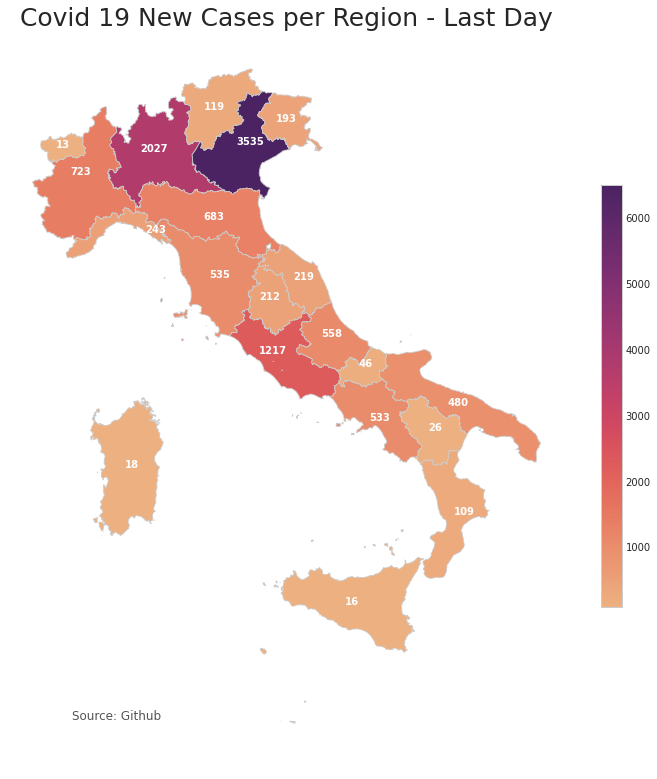

In [17]:
 #set a variable that will call whatever column we want to visualise on the map
variable = 'new_cases'
# set the range for the choropleth
vmin, vmax = 100, 6500
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 12))

# create map
merged.plot(column=variable, cmap='flare', linewidth=0.8, ax=ax, edgecolor='0.8' )

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Covid 19 New Cases per Region - Last Day', fontdict={'fontsize': '25', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate('Source: Github ',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='flare' ,norm=plt.Normalize(vmin=vmin, vmax=vmax))

for idx, row in merged.iterrows():
   ax.annotate(text= row['new_cases'], xy=row['coords'], horizontalalignment='center', color='white',   fontweight='bold')

# empty array for the data range
sm._A = []

# add the colorbar to the figure0
cbar = fig.colorbar(sm,shrink = 0.5)

#fig.savefig('map_export.png', dpi=300)              

In [18]:
# sort values by new_cases
data_for_map = data_for_map.sort_values(by='new_cases', ascending= False)

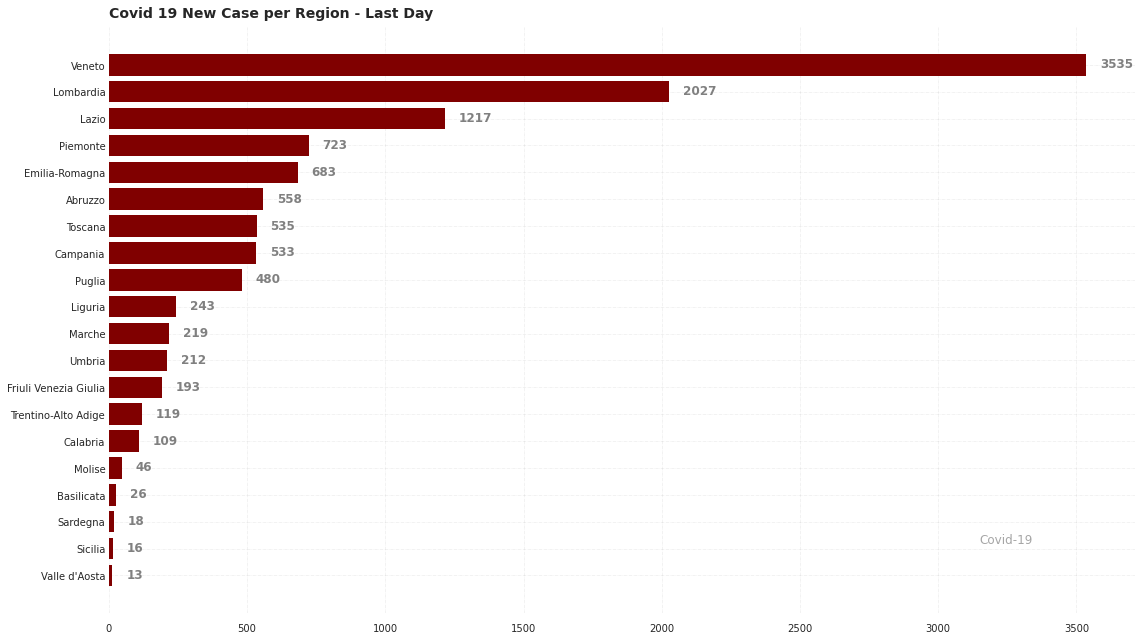

In [19]:
name = data_for_map['DEN_REG']
cases = data_for_map['new_cases']
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(name, cases,color ='maroon')
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# x, y Ticks
ax.xaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() + 50.2, i.get_y() +0.5,
         str(round((i.get_width()), 2)),
         fontsize = 12, fontweight ='bold',
         color ='grey')

# Add Plot Title
ax.set_title('Covid 19 New Case per Region - Last Day',
             loc ='left', )
 
# Add Text watermark
fig.text(0.9, 0.15, 'Covid-19', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

<a id="2.4"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Exploratory data analysis</h1>

In [20]:
# plot new_cases with navigation slice
fig = my_plot(covid, 'new_cases',ylabel = "new cases",title="Covid 19 Italy New Cases", navigate = 1)
fig.show()

# Pareto diagram for new cases

<p><strong>The Pareto principle</strong>, also known as the 80-20 rule, is a management tool that suggests that roughly 80% of the effects come from 20% of the causes. This principle is often used to identify the most significant factors contributing to a problem or issue, with the goal of focusing efforts on the most impactful causes in order to achieve the greatest results.</p>
<p>In the context of a Pareto diagram, the 80-20 rule is often used to identify the most significant categories of data.&nbsp; Analyzing the distribution of new Covid-19 cases over time,&nbsp;<strong> a Pareto diagram can help to identify the most significant time periods or categories that account for the majority of new cases</strong>.</p>
<p>&nbsp;</p>



In [21]:
# cumulative cases
covid['cumperc'] = covid['new_cases'].cumsum()/covid['new_cases'].sum()*100

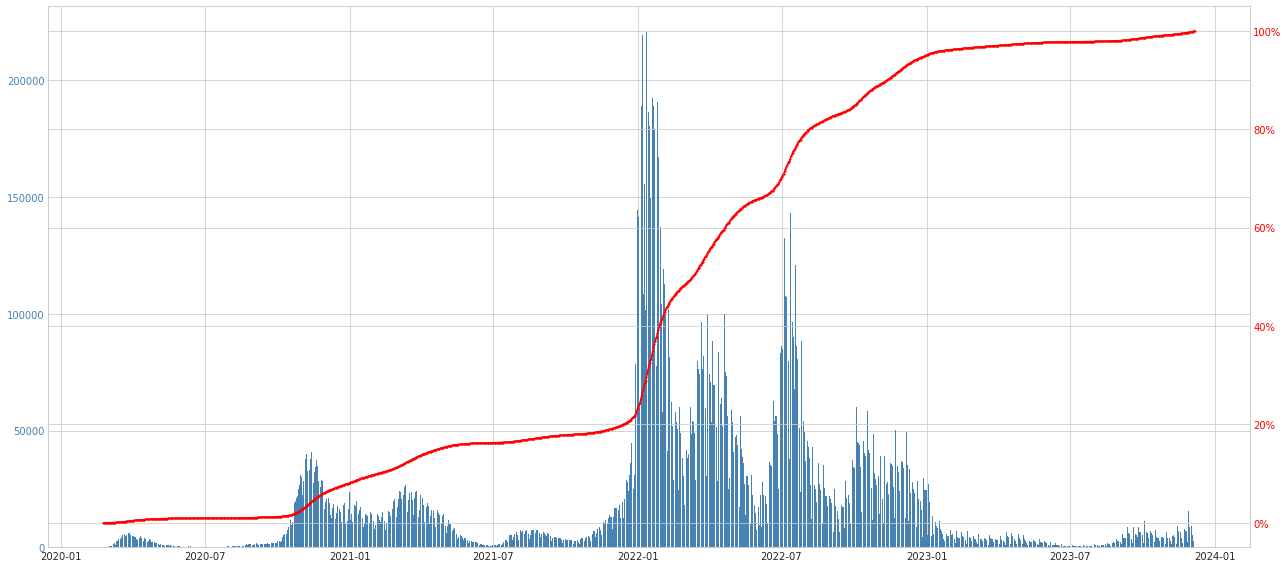

In [22]:
#pareto diagram per cases

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 1

#create basic bar plot
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(covid.index, covid['new_cases'], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(covid.index, covid['cumperc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

> <h2><span style="background-color: #800000; color: #ffffff;"><strong>The majority of case are in 2022 in the pandemic tail!</strong></span></h2>

In [23]:
#last three months
df_three_months = last_n_months(covid,3)

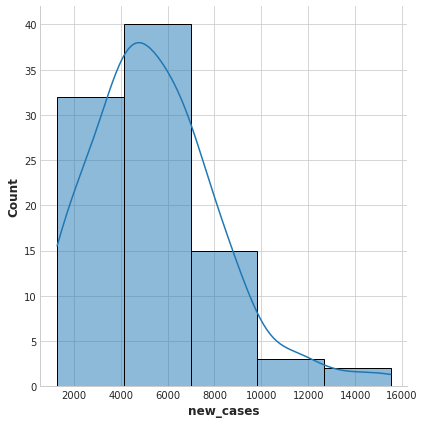

In [24]:
#distribution plot
sns.displot(df_three_months['new_cases'],bins=5,kde=True,height = 6)
plt.show()

In [25]:
# plot  Last 3 months
fig = my_plot(df_three_months, 'new_cases',ylabel = "new cases",title="Covid 19 Italy New Cases - Last 3 months ", navigate = 0)
fig.show()

# Heatmaps for Covid new cases for Weekdays - Last three months

<p><strong>Heatmaps</strong> are graphical representations of data that use colors to indicate the density or intensity of the data at different points on a map. They can be useful for visualizing and understanding patterns and trends in data over time or in different geographical areas.</p>
<p>In the context of Covid-19, heatmaps could be used to <strong>show the distribution of new cases on weekdays over the last three months</strong>. This could provide insights into how the disease has spread over time and how it may have been impacted by factors such as public health interventions, seasonal changes, or other factors.</p>

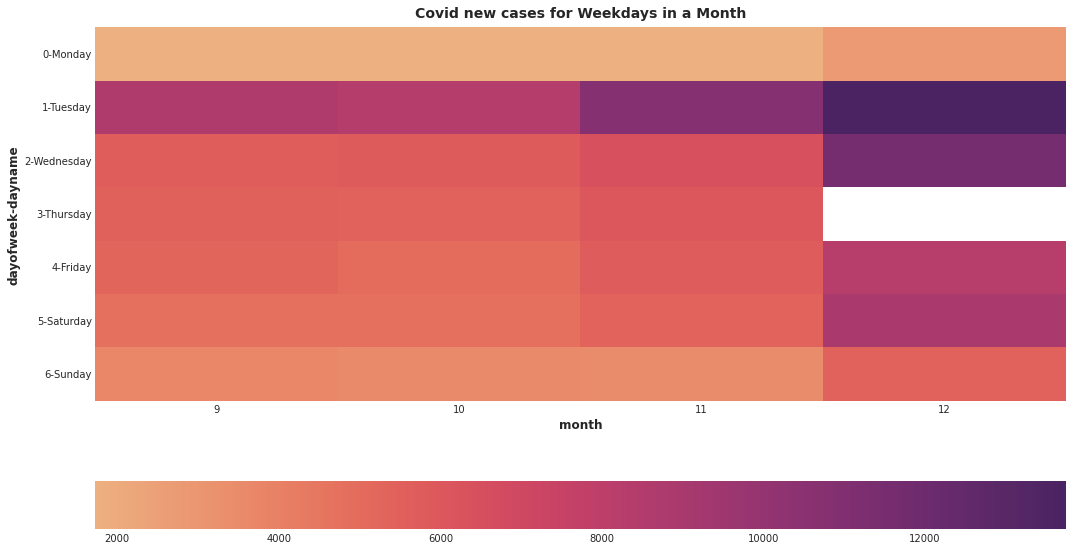

In [26]:
# aggregate on 'dayofweek','dayname','month' with mean of the new_cases
df_three_months_mean = df_three_months[['dayofweek','dayname','month','new_cases']].groupby(['dayofweek','dayname','month']).agg({'new_cases' : 'mean'})
df_three_months_mean = df_three_months_mean.reset_index().pivot(index=['dayofweek','dayname'], columns='month', values='new_cases')

ax = plt.subplots(figsize=(15, 8))
plt.title('Covid new cases for Weekdays in a Month')

ax = sns.heatmap(df_three_months_mean,cmap="flare", 
                  cbar_kws={"orientation": "horizontal"})


> <h2><span style="background-color: #800000; color: #ffffff;"><strong>On Tuesday we have the peak for new cases</strong></span></h2>

# New cases last month 

In [27]:
#last month
df_last_month = last_n_months(covid,1)

In [28]:
# visualize last month of data
cm = sns.light_palette("#b30000", as_cmap=True)
 
# Visualizing the DataFrame with set precision

df_last_month[['new_cases','dayname']].style.background_gradient(cmap=cm).set_precision(2)



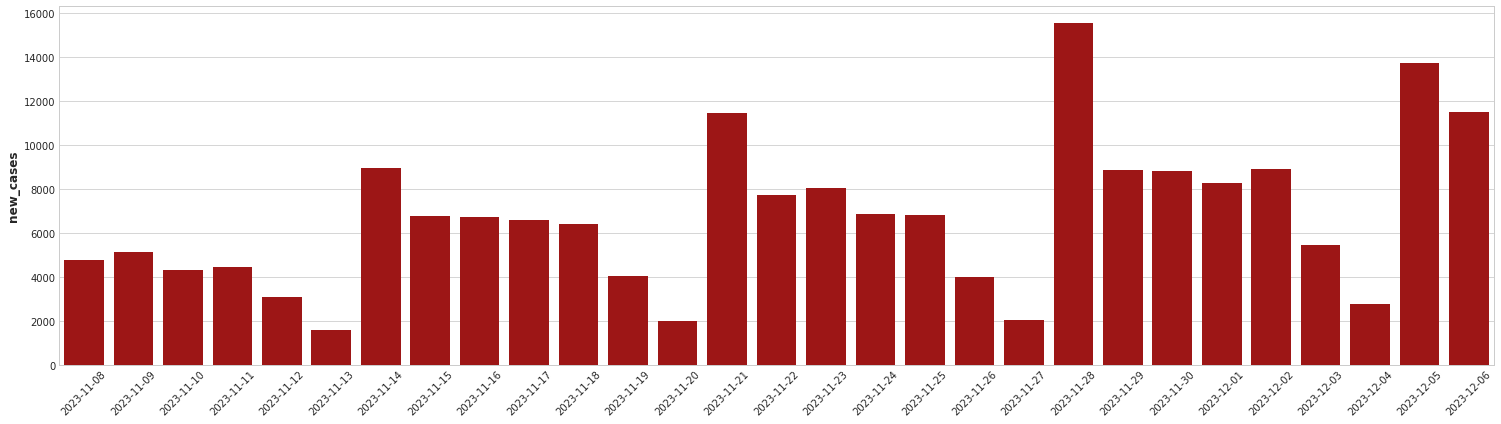

In [29]:
#last month bar plot
f, ax = plt.subplots(figsize = (21,6))
#sns.set_color_codes('pastel')
sns.barplot(x= df_last_month.index.date, y = "new_cases",  ci = None, data = df_last_month, color = '#b30000')
plt.xticks(rotation=45)
plt.show()

<a id="3"></a>
<h1 style="background-color:#800000;font-family:Serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Build SarimaX Model</h1>

* **SARIMAX**, short for "Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors," is a statistical model that can be used to analyze and forecast time series data. It is a type of Box-Jenkins model, which is a class of models that are used to analyze and forecast time series data.

* **The SARIMAX model is an extension of the basic ARIMA** (AutoRegressive Integrated Moving Average) model, which is used to analyze and forecast stationary time series data. The SARIMAX model includes the ability to include seasonal components, as well as exogenous variables, in the model.

* **The seasonal component** of the SARIMAX model allows the model to take into account seasonal patterns in the time series data. For example, a time series of retail sales might show higher sales during the holiday season compared to other times of the year. The SARIMAX model can account for this seasonal pattern in the data.

* **Exogenous variables**, also known as "exogenous regressors," are variables that are not part of the time series data being analyzed, but which may have an influence on the time series. For example, a time series of unemployment rates might be influenced by economic policies or other external factors. The SARIMAX model can include these exogenous variables in the model in order to improve the accuracy of the forecasts.

Overall, the SARIMAX model is a *powerful tool for analyzing and forecasting time series data*, especially when there are seasonal patterns or external factors that need to be taken into account.

<a id="3.1"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Data preparation for SarimaX</h1>

In [30]:
covid = covid[['new_cases', 'holiday']]
covid.index.freq = 'D'

In [31]:
steps = 7
train = covid.iloc[:-steps]
test = covid.iloc[len(train):]

In [32]:
endog = train[['new_cases']]
covid_ex = covid[['holiday']]
exog = pd.get_dummies(covid_ex)
train_exog = exog.iloc[:-steps]

<a id="3.2"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">SARIMA ACF/PACF</h1>

<h1>Seasonal Decomposition</h1>
<p><strong>Seasonal decomposition</strong> is a statistical method that is used to decompose a time series into its component parts: trend, seasonality, and residuals. This can be helpful for understanding the underlying patterns in the time series data and for making more accurate forecasts.</p>
<h2>Components of Seasonal Decomposition</h2>
<ul>
  <li><strong>Trend</strong> is the long-term direction of the time series data, whether it is increasing, decreasing, or remaining relatively constant over time.</li>
  <li><strong>Seasonality</strong> refers to repeating patterns within the data, such as monthly or yearly cycles.</li>
  <li><strong>Residuals</strong> are the remaining part of the time series data that cannot be explained by the trend or seasonality.</li>
</ul>
<h2>Methods for Seasonal Decomposition</h2>
<p>There are several methods for performing seasonal decomposition, including:</p>
<ol>
  <li><strong>Additive decomposition</strong>: This method is used when the magnitude of the seasonal fluctuations remains constant over time. The time series is decomposed into the trend, seasonal, and residual components as follows:
      <br /> <br />
   $ trend = {original\ time\ series} - {seasonal\ component} - {residual component}$
  </li>
    <br/>
  <li><strong>Multiplicative decomposition</strong>: This method is used when the magnitude of the seasonal fluctuations changes over time. The time series is decomposed into the trend, seasonal, and residual components as follows:
       <br /> <br />
   $trend = \large  \frac{original\ time\ series}{{seasonal\ component}*{residual\ component}}$
  </li>
</ol>


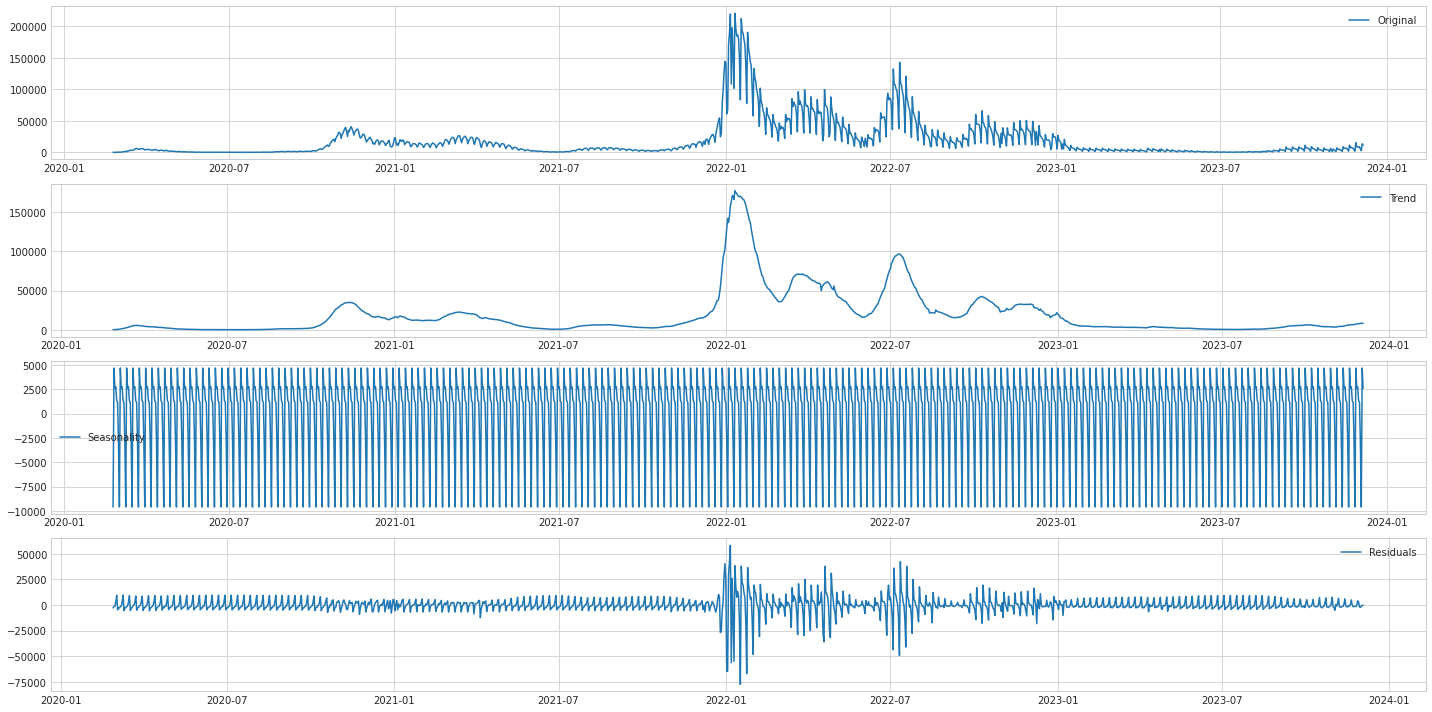

In [33]:
decomp=seasonal_decompose(covid['new_cases'])

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.figure(figsize=(20,10))

plt.subplot(411)
plt.plot(covid['new_cases'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


<h2>Checking the Stationarity of a Time Series</h2>
<p>Checking the <strong>stationarity</strong> of a time series is an important step in time series analysis, as it helps to determine whether the series is stable or whether it is trended or seasonal. <br/> A stationary time series is one in which the mean, variance, and autocorrelation structure do not change over time.</p>
<h3>Methods for Testing Stationarity</h3>
<ol>
  <li>Visual inspection: One way to check for stationarity is to plot the time series and look for any clear trends or seasonality.</li><br/>
  <li>Augmented Dickey-Fuller (ADF) test: This statistical test checks for a unit root in the time series, which indicates a non-stationary series. <br/> If the p-value is less than a certain threshold (usually 0.05), then the null hypothesis of a unit root can be rejected and the series can be considered stationary.</li><br/>
  <li>Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: This statistical test checks for a trend in the time series, which indicates a non-stationary series. <br/>If the p-value is greater than a certain threshold (usually 0.05), then the null hypothesis of a trend can be accepted and the series can be considered stationary.</li><br/>
</ol>

In [34]:
# Augmented Dickey-Fuller Test:
adf_test(covid['new_cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -4.195436
p-value                    0.000671
# lags used               17.000000
# observations          1364.000000
critical value (1%)       -3.435153
critical value (5%)       -2.863661
critical value (10%)      -2.567899
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


<h1>Autocorrelation and partial autocorrelation plot</h1>
<p><b>Autocorrelation</b>, sometimes known as serial correlation in the discrete time case, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations as a function of the time lag between them.</p>
<p>In time series analysis, the <b>partial autocorrelation function (PACF)</b> gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.</p>
<p>The <b>autocorrelation plot (ACF)</b> and <b>partial autocorrelation plot (PACF)</b> are graphical tools that can be used to identify patterns in time series data and to help select an appropriate model for forecasting.</p>
<p>The ACF is a plot of the autocorrelation of a time series at different lag intervals. It is used to identify patterns in the time series data that may indicate the presence of a trend, seasonality, or other systematic structure.</p>
<p>The PACF is a plot of the partial autocorrelation of a time series at different lag intervals. It is used to identify patterns in the time series data that may indicate the presence of an underlying autoregressive (AR) or moving average (MA) model.</p>
<p>Both the ACF and PACF can be used to help select an appropriate model for forecasting a time series. For example, if the ACF shows a significant correlation at a particular lag interval, this may indicate the presence of an AR model, while if the PACF shows a significant correlation at a particular lag interval, this may indicate the presence of an MA model.</p>
<p>Overall, the ACF and PACF are useful tools for understanding the underlying patterns in a time series and for selecting an appropriate model for forecasting.</p>

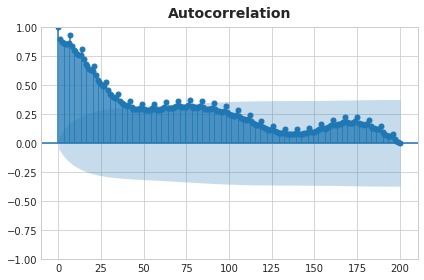

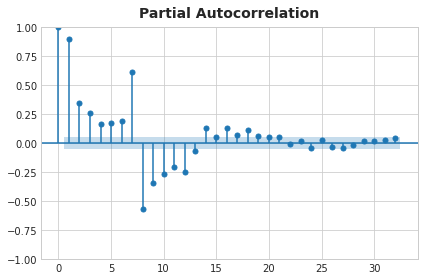

In [35]:

plot_acf(covid['new_cases'], lags = 200)
plot_pacf(covid['new_cases'])
plt.show()

**If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
d = 1**

In [36]:
covid_diff = pd.DataFrame()
covid_diff['new_cases'] = covid['new_cases'].diff(periods=1).dropna().copy()

In [37]:
adf_test(covid_diff['new_cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.984108e+00
p-value                 2.576416e-12
# lags used             1.900000e+01
# observations          1.361000e+03
critical value (1%)    -3.435164e+00
critical value (5%)    -2.863666e+00
critical value (10%)   -2.567902e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


<Figure size 1440x720 with 0 Axes>

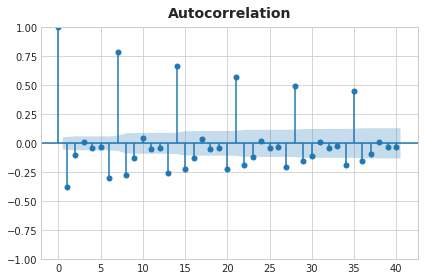

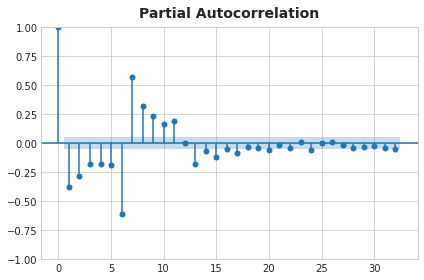

In [38]:
plt.figure(figsize=(20,10))

plot_acf(covid_diff['new_cases'], lags = 40)
plt.show()
plot_pacf(covid_diff['new_cases'])
plt.show()

**Considerations: **

If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., 

the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is
the indicated number of MA terms.

<a id="3.3"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Find optimal hyperparameters</h1>

<h1>SarimaX hyperparameters</h1>
<p><strong>SARIMAX</strong> (Seasonal Autoregressive Integrated Moving Average with eXogenous regressors) is a type of statistical model used for forecasting time series data. It is an extension of the standard SARIMA model that includes the ability to incorporate additional exogenous variables (also known as explanatory variables or regressors) into the model.</p>
<p>There are several hyperparameters that need to be specified when fitting a SARIMAX model. These include:</p>
<ol>
<li>p: The order of the <strong>autoregressive</strong> (AR) component of the model. This is the number of lagged values of the time series used to predict the current value.</li>
<li>d: The order of <strong>differencing</strong>. This is the number of times the time series needs to be differenced in order to make it stationary.</li>
<li>q: The order of the <strong>moving average</strong> (MA) component of the model. This is the number of lagged forecast errors used to predict the current value.</li>
<li>P: The order of the <strong>seasonal autoregressive</strong> component of the model. This is the number of lagged values of the time series used to predict the current value, with a lag equal to the seasonal period.</li>
<li>D: The order of <strong>seasonal differencing</strong>. This is the number of times the time series needs to be differenced in order to make it stationary, with a lag equal to the seasonal period.</li>
<li>Q: The order of the <strong>seasonal moving average</strong> component of the model. This is the number of lagged forecast errors used to predict the current value, with a lag equal to the seasonal period.</li>
<li>m: <strong>The number of periods in a season</strong>. This is the number of time steps that make up a seasonal period.</li>
</ol>
<p>In addition to these parameters, you may also need to specify the number of exogenous variables and the values of any hyperparameters related to those variables, such as the order of their autoregressive or moving average components.</p>
<p><strong>Optimizing these hyperparameter</strong>s is an important part of fitting a SARIMAX model, as the correct values can have a significant impact on the accuracy of the model. This can be done using techniques such as grid search or optimization algorithms.</p>

<h2>Find optimal parameters with Auto-ARIMA (Autoregressive Integrated Moving Average)</h2>
<p><strong> Auto-ARIMA</strong> is a method for automatically selecting the optimal hyperparameters for an ARIMA model, which is a statistical model used for forecasting time series data. ARIMA models are characterized by three hyperparameters: p, d, and q, which correspond to the order of the autoregressive (AR), differencing, and moving average (MA) components of the model, respectively.</p>
<p>To find the optimal hyperparameters for an ARIMA model using Auto-ARIMA, you can use the auto_arima function from the <strong>pmdarima</strong> library in Python. This function uses an optimization algorithm to search over a range of possible hyperparameter values and select the ones that result in the best fit to the data. To use the auto_arima function, you will need to provide it with your time series data and specify any additional constraints or options you would like to use.</p>
<p>&nbsp;</p>
<p>For example, you can specify the maximum order of the autoregressive and moving average components, or you can specify whether to include or exclude seasonal components in the model.</p>

In [39]:
stepwise_fit = auto_arima(endog, seasonal = True,trace = True, m= 7,exogenous=train_exog, maxiter  = 100) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=28283.182, Time=8.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30097.042, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28500.546, Time=1.96 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=28851.182, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30095.043, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=28866.058, Time=2.80 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=28459.709, Time=2.50 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=28205.653, Time=20.24 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=28452.970, Time=5.52 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=22.96 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=28454.679, Time=7.20 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=15.27 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=18.71 sec
 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=28455.932, Time=6.74 sec
 ARIMA(2,1,3)(2,0,1)[7] intercept

<a id="4"></a>
<h1 style="background-color:#800000;font-family:Serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Predict and Evaluate the model</h1>

In [40]:
#prepare forecast
start_index = len(train) 

#forecast N steps
end_index = start_index + steps 

#exogenous features 
exog_forecast =  exog.iloc[start_index-1:end_index-1] 

<a id="4.1"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Predict</h1>

In [41]:
# dataframe test = last seven days
test = covid[['new_cases']].iloc[start_index:]
predictions = pd.DataFrame(stepwise_fit.predict(exogenous=exog_forecast, n_periods = steps), index=test.index)

# Actual vs Predicted

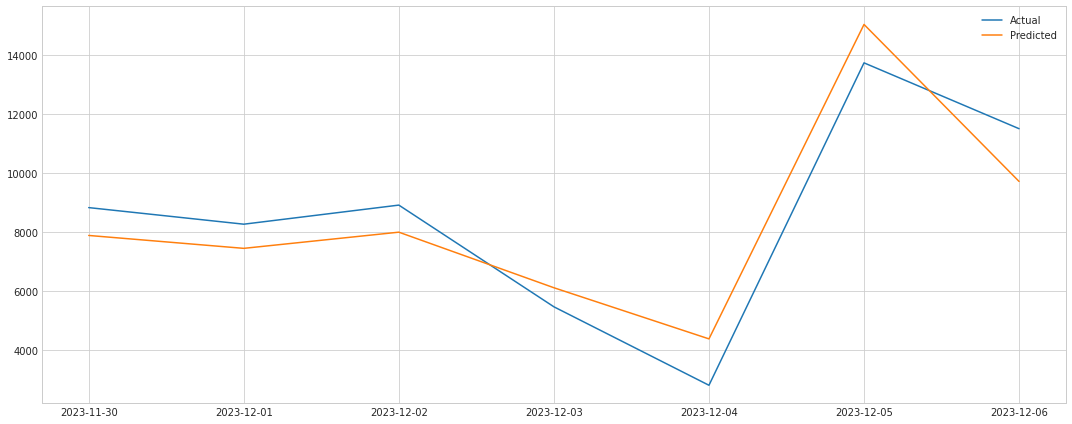

In [42]:
# actual vs predicted

plt.rcParams["figure.figsize"] = [15, 6]
ax = plt.gca()

plt.plot(test['new_cases'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

<a id="4.2"></a>
<h1 style="background-color:#800000;font-family:serif;font-size:200%;color: #fff;text-align:center;border-radius: 50px 50px;">Evaluate the model</h1>

<h1>Error metrics</h1>
<ul>
  <li><b>R2</b>: R2, also known as the coefficient of determination, is a measure of the goodness of fit of a statistical model. It is defined as the proportion of the variance in the dependent variable that is explained by the model. R2 ranges from 0 to 1, with higher values indicating a better fit.</li>
  <li><b>MSE</b> (Mean squared error): MSE is a measure of the average squared difference between the predicted values of a model and the true values. It is calculated by taking the sum of the squared differences between the predicted and true values, dividing by the number of samples, and taking the square root. MSE is often used as a loss function in machine learning algorithms, with the goal being to minimize the MSE.</li>
  <li><b>RMSE</b> (Root mean squared error): RMSE is a measure of the average magnitude of the errors in a model's predictions. It is calculated by taking the square root of the MSE. RMSE is a commonly used metric for evaluating the performance of a model, particularly in the context of regression tasks.</li>
  <li><b>MAE</b> (Mean absolute error): MAE is a measure of the average magnitude of the errors in a model's predictions, without considering their direction. It is calculated by taking the absolute value of the difference between the predicted and true values for each sample, and then averaging those values. MAE is less sensitive

In [43]:
# error metrics
error_metrics(test['new_cases'], predictions)

R2: 0.870
MSE (Mean squared error): 1,459,916
RMSE (Root mean squared error): 1,208
MAE (Mean absolute error): 1,143
MdAE (Median absolute error ): 946
MAPE (Mean percentage error): 17.75%


<h1>plot_diagnostics()</h1>


<p><strong>stepwise_fit.plot_diagnostics()</strong> is a method that can be used to diagnose the fit of a stepwise regression model. Stepwise regression is a type of regression model selection method in which the model is iteratively fit by adding or removing predictors based on the statistical significance of their contribution to the model.</p>
<p>The plot_diagnostics() method generates diagnostic plots for a stepwise regression model fit using the statsmodels library in Python. These plots can be used to assess the fit of the model and identify any potential issues or problems with the model.</p>
<p>The diagnostic plots generated by plot_diagnostics() include:</p>
<ol>
<li><strong>A residual plot</strong>: This plot shows the residuals (prediction errors) of the model as a function of the predicted values. The residuals should be randomly distributed around zero, with no discernible pattern. If there is a pattern present, it may indicate a problem with the model.</li>
<li><strong>A Q-Q plot</strong>: This plot compares the quantiles of the residuals to a standard normal distribution. If the residuals are normally distributed, the points in the plot should fall along a straight line. If they do not, it may indicate a problem with the model.</li>
<li><strong>A scale-location plot</strong>: This plot shows the square root of the absolute residuals as a function of the predicted values. The residuals should be evenly distributed around the horizontal line at y=0. If the points are more spread out for larger or smaller predicted values, it may indicate a problem with the model.</li>
<li><strong>A leverage plot</strong>: This plot shows the leverage of each sample in the model. High leverage points may have a disproportionate influence on the fit of the model, and may indicate the presence of outliers or influential points.</li>
</ol>
<p>Overall, the diagnostic plots generated by plot_diagnostics() can be useful for identifying potential issues with the fit of a stepwise regression model and for assessing the model's performance.</p>

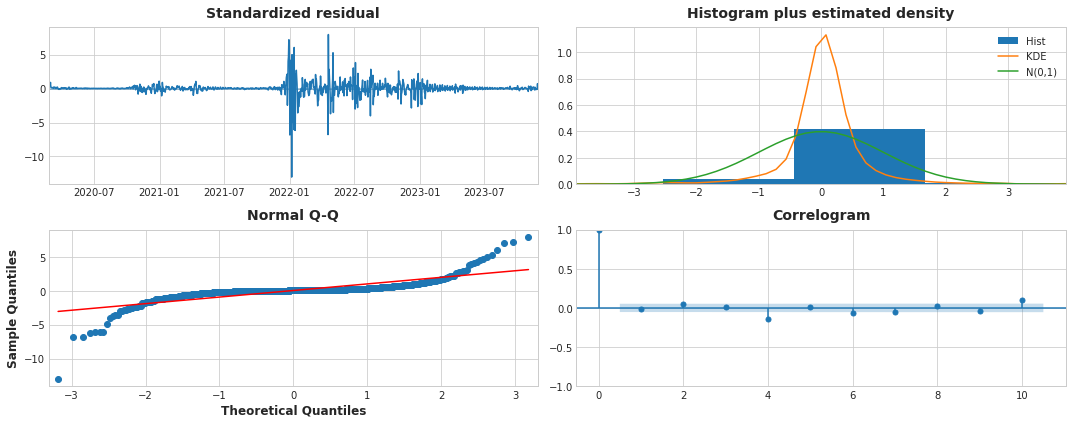

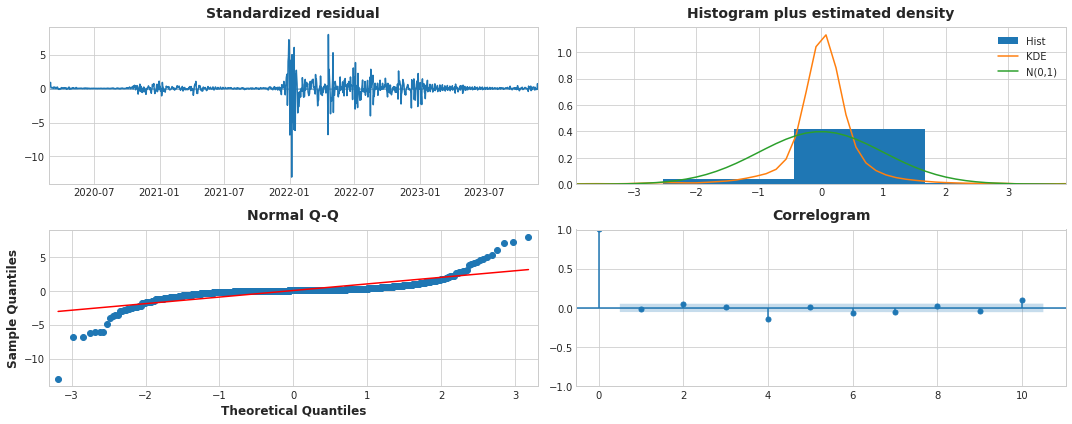

In [44]:
# model diagnostic
stepwise_fit.plot_diagnostics()

**Histogram plus estimated density plot**: If the red KDE line follows closely with the N(0,1) line, it is an indication that the residuals are not normally distributed.

**The Q-Q-plot** : If the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1), 
it is an indication that the residuals are normally distributed.

**The standardize residual plot**: If the residuals over time don’t display any obvious seasonality they appear to be white noise.

**The Correlogram plot**: Shows that the time series residuals correlation with lagged versions of itself.

